---
# US Generic file
---
Determine oil type weighting for tank traffic in MIDOSS monte-carlo by cataloguing information in Department of Ecology's recorded marine terminal transfers for 2018.  Only transfers greater than 1000 L are required to be documented. All imports and exports are catalogued by vessel and oil types used in this study, across all the marine terminals used in this category. 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte_carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

# This is the precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 'Shell Oil LP Seattle Distribution Terminal',
                   'Maxum (Rainer Petroleum)', 'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Nustar Energy Tacoma', 'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP Management Services LLC (TMS)']

# define vessel and oil types to include in .yaml file
vessel_types = ['atb', 'barge', 'tanker']
oil_types    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']

In [3]:
# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (oiling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float).round(precision)

# housekeeping
df['Receiver'] = df['Receiver'].str.replace('US Oil Tacoma ', 'U.S. Oil & Refining')
df['Receiver'] = df['Receiver'].str.replace('TLP', 'TLP Management Services LLC (TMS)')
df['Deliverer'] = df['Deliverer'].str.replace('US Oil Tacoma ', 'U.S. Oil & Refining')
df['Deliverer'] = df['Deliverer'].str.replace('TLP', 'TLP Management Services LLC (TMS)')

## Create name lists for the DOE oil types used in our monte-carlo oil categories

In [4]:
# identify all names of oils in DOE database that are attributed to our oil types
oil_classification = {}
for oil in oil_types:
    oil_classification[oil] = []

[nrows,ncols] = df.shape
for row in range(nrows):
    if 'CRUDE' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BAKKEN' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BUNKER' in df.Product[row] and df.Product[row] not in oil_classification['bunker']:
        oil_classification['bunker'].append(df.Product[row])
    elif 'BITUMEN' in df.Product[row] and df.Product[row] not in oil_classification['dilbit']:
        oil_classification['dilbit'].append(df.Product[row])
    elif 'DIESEL' in df.Product[row] and df.Product[row] not in oil_classification['diesel']:
        oil_classification['diesel'].append(df.Product[row])
    elif 'GASOLINE' in df.Product[row] and df.Product[row] not in oil_classification['gas']:
        oil_classification['gas'].append(df.Product[row])
    elif 'JET' in df.Product[row] and df.Product[row] not in oil_classification['jet']:
        oil_classification['jet'].append(df.Product[row])
    elif ('CRUDE' not in df.Product[row] and
          'BAKKEN' not in df.Product[row] and
          'BUNKER' not in df.Product[row] and
          'BITUMEN' not in df.Product[row] and
          'DIESEL' not in df.Product[row] and
          'GASOLINE' not in df.Product[row] and
          'JET' not in df.Product[row] and
          df.Product[row] not in oil_classification['other']):
        oil_classification['other'].append(df.Product[row])

oil_classification

{'akns': ['CRUDE OIL', 'BAKKEN'],
 'bunker': ['BUNKER OIL/HFO'],
 'dilbit': ['BITUMEN OIL (DIL OR SYN)'],
 'jet': ['JET FUEL/KEROSENE'],
 'diesel': ['DIESEL/MARINE GAS OIL', 'BIODIESEL', 'DIESEL LOW SULPHUR (ULSD)'],
 'gas': ['GASOLINE'],
 'other': ['ETHANOL',
  'LUBE OIL/MOTOR OIL',
  'Cat Feed/VGO',
  'CUTTER STOCK',
  'OILY WATER MIXTURE',
  'WASTE OIL',
  'Z-OTHER',
  'HYDRAULIC OIL',
  'OILY WASTE',
  'USED OIL',
  'NAPTHA',
  'EDIBLE/VEGETABLE OIL',
  'DECANT OIL',
  'NONENE',
  'ASPHALT/CREOSEOTE']}

### Create a dataframe that combines imports and exports from our selected marine terminals so that we can query based on ship-type and yield the combined sum of imports and exports

In [5]:
import_export_df = df.loc[        
        (df.Receiver.isin(facility_names)) |
        (df.Deliverer.isin(facility_names)) &
        (df.TransferType == 'Cargo'),
    ]
print(f'Combined df shape: {import_export_df.shape}')



Combined df shape: (4391, 7)


### Tally up total volume transferred by ship type

In [6]:
# This is the total gallons transferred by ship type and summed over all oil types
total = {}
## Tally up exports by ship type
for vessel in vessel_types:
    if vessel =='tanker':
        tanker_import_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK SHIP'])) &
            (df.Receiver.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        tanker_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK SHIP'])) &
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        total['tanker'] = tanker_import_total + tanker_export_total
        
    elif vessel == 'atb':
        atb_import_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (df.Deliverer.str.contains('ITB')) | (df.Deliverer.str.contains('ATB')) & 
            (df.Receiver.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        atb_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (df.Receiver.str.contains('ITB')) | (df.Receiver.str.contains('ATB')) & 
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()       
        total['atb'] = atb_import_total + atb_export_total
        
    elif vessel == 'barge':
        barge_import_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (~df.Deliverer.str.contains('ITB')) & (~df.Deliverer.str.contains('ATB')) &
            (df.Receiver.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        barge_export_total = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (~df.Receiver.str.contains('ITB')) & (~df.Receiver.str.contains('ATB')) &
            (df.Deliverer.isin(facility_names)), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        total['barge'] = barge_import_total + barge_export_total

## Sort cargo transfers by ship types.  We have three categories: tanker, atb, barge.
1. `tanker`: Listed in DOE dataset as `TANK SHIP` TypeDescription 
2. `atb`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription and `ATB` or `ITB` as Deliverer/Receiver
3. `barge`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription (no `ATB` or `ITB` in Deliverer/Receiver)

## Tally up `total_gallons`, `number_of_transfers`, `fraction_of_total`, where:
- `total_gallons`: Total gallons transfered for the particular oil type
- `fraction_of_total`: (`total_gallons` by oil type) / (total gallons across oil types)
- `number_of_transfers`: Total transfers for the particular oil type

I use `import_export_df` to pre-select cargo transfers to/from our selected marine terminals.  I tried many things here to try to force creation of fractions that sum to 1.0, including:
1. multipling by 100*int(numerator), integer divide (//) int(denominator), then divide ratio by 100 to convert back to float, e.g.:
```
test = (100 * int(2))//int(3)
test/100
```
2. Using decimal_divide and setting precision (which only appears to do anything for precision <= 2), e.g.:
```
destination[facility][vessel][oil]['fraction_of_total'] = decimal_divide(
     int(destination[facility][vessel][oil]['total_gallons']), 
     int(tanker_import_total[facility]),
     precision
 ).round(precision)
```
3. Dividing two integers (the method I am sticking with as it's cleaner than (1) and just as effetive)

In [8]:
all_US = {} # this is the output dictionary
import_US = {}
export_US = {}
for vessel in vessel_types:
    all_US[vessel] = {}
    import_US[vessel] = {}
    export_US[vessel] = {}
    for oil in oil_types:
        all_US[vessel][oil] = {}
        import_US[vessel][oil] = {}
        export_US[vessel][oil] = {}
        for data in data_types:
            all_US[vessel][oil][data] = 0
            import_US[vessel][oil][data] = 0
            export_US[vessel][oil][data] = 0

### Combined tanker imports and exports

In [9]:
vessel = 'tanker'
type_description = ['TANK SHIP']

In [10]:
# Now estimat fractions of total by oil types
for oil in oil_types:
    import_US[vessel][oil]['total_gallons'] = df.loc[
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK SHIP'])) &
            (df.Receiver.isin(facility_names)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ]
    
    export_US[vessel][oil]['total_gallons'] = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(['TANK SHIP'])) &
            (df.Deliverer.isin(facility_names)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ]
    
    # Add up net oil quantity transferred by oil_types
    all_US[vessel][oil]['total_gallons'] = (
        import_US[vessel][oil]['total_gallons'].sum(axis=0).item() + 
        export_US[vessel][oil]['total_gallons'].sum(axis=0).item()
    )

    # Calculate the fraction of total oil transfer represented 
    # by this oil type
    if total[vessel] != 0:
        all_US[vessel][oil]['fraction_of_total'] = (
            int(all_US[vessel][oil]['total_gallons'])/
            int(total[vessel])
        )
    
    # Catalogue the number of transfers 
    all_US[vessel][oil]['number_of_transfers'] = (
        import_US[vessel][oil]['total_gallons'].shape[0] + 
        export_US[vessel][oil]['total_gallons'].shape[0]
    )     

### ATB imports and exports

In [11]:
vessel = 'atb'
type_description = ['TANK BARGE','TUGBOAT']

# Now estimat fractions of total by oil types
for oil in oil_types:

    import_US[vessel][oil]['total_gallons'] = df.loc[
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(type_description)) &
            (df.Deliverer.str.contains('ITB')) | 
            (df.Deliverer.str.contains('ATB')) &
            (df.Receiver.isin(facility_names)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ]
    
    export_US[vessel][oil]['total_gallons'] = df.loc[
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(type_description)) &
            (df.Receiver.str.contains('ITB')) |
            (df.Receiver.str.contains('ATB')) & 
            (df.Deliverer.isin(facility_names)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ]
    
    # Add up net oil quantity transferred by oil_types
    all_US[vessel][oil]['total_gallons'] = (
        import_US[vessel][oil]['total_gallons'].sum(axis=0).item() + 
        export_US[vessel][oil]['total_gallons'].sum(axis=0).item()
    )

    # Calculate the fraction of total oil transfer represented 
    # by this oil type    
    if total[vessel] != 0:
        all_US[vessel][oil]['fraction_of_total'] = (
            int(all_US[vessel][oil]['total_gallons'])/
            int(total[vessel])
        )       

    # Catalogue the number of transfers 
    all_US[vessel][oil]['number_of_transfers'] = (
        import_US[vessel][oil]['total_gallons'].shape[0] + 
        export_US[vessel][oil]['total_gallons'].shape[0]
    ) 

### Tank barge imports and exports

In [12]:
vessel = 'barge'
type_description = ['TANK BARGE','TUGBOAT']

for oil in oil_types:

    # Add up net oil quantity transferred by oil_types
    import_US[vessel][oil]['total_gallons'] = df.loc[
        (df.TransferType == 'Cargo') &
        (df.DelivererTypeDescription.isin(type_description))  &
        (~df.Deliverer.str.contains('ITB')) & 
        (~df.Deliverer.str.contains('ATB')) &
        (df.Receiver.isin(facility_names)) &
        (df.Product.isin(oil_classification[oil])),
        'TransferQtyInGallon'
    ]
    
    export_US[vessel][oil]['total_gallons'] = df.loc[
        (df.TransferType == 'Cargo') &
        (df.ReceiverTypeDescription.isin(type_description)) &
        (~df.Receiver.str.contains('ITB')) &
        (~df.Receiver.str.contains('ATB')) & 
        (df.Deliverer.isin(facility_names)) &
        (df.Product.isin(oil_classification[oil])),
        'TransferQtyInGallon'
    ]
        
    # Calculate the fraction of total oil transfer represented 
    # by each oil type            
    if total[vessel] != 0:
        all_US[vessel][oil]['fraction_of_total'] = (
            int(all_US[vessel][oil]['total_gallons'])/
            int(total[vessel])
        )

    # Catalogue the number of transfers 
    all_US[vessel][oil]['number_of_transfers'] = (
        import_US[vessel][oil]['total_gallons'].shape[0] + 
        export_US[vessel][oil]['total_gallons'].shape[0]
    ) 

### QAQC: Make sure oil fractions sum to 1.0 (and fix if they don't)

In [13]:
## print out errors first to make sure they are reasonable
for vessel in vessel_types:        
    total = sum([all_US[vessel][oil]['fraction_of_total'] for oil in oil_types])    
    if (total != 1) & (total != 0):
        print(f'{vessel}, {total}')
        print([all_US[vessel][oil]['fraction_of_total'] for oil in oil_types])

atb, 1.1700715972479214
[0.04742806222929411, 0.142359776113322, 0.028345266207986913, 0.15672866495418034, 0.27724624119179736, 0.4224963785903752, 0.09546720796096549]


## Write to file

In [14]:
with open(r'./US_general.yaml', 'w') as file:
    documents = yaml.safe_dump(all_US, file)

## Plot results

In [15]:
US = all_US

Text(0.5, 1.0, 'tanker fuel allocation for general = US')

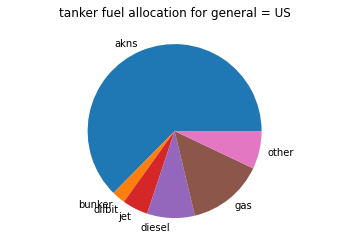

In [16]:
label = 'tanker'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for general = US')

Text(0.5, 1.0, 'atb fuel allocation for general = US')

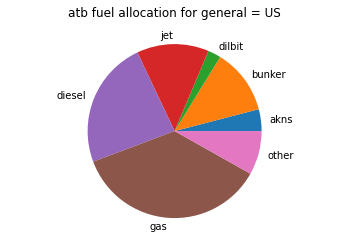

In [17]:
label = 'atb'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for general = US')

<ipython-input-18-5a114eed1063>:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(US_tank, labels= oil_types)


Text(0.5, 1.0, 'barge fuel allocation for general = US')

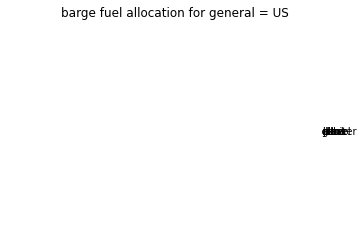

In [18]:
label = 'barge'
US_tank = [ US[label]['akns']['total_gallons'], 
                US[label]['bunker']['total_gallons'], 
                US[label]['dilbit']['total_gallons'], 
                US[label]['jet']['total_gallons'], 
                US[label]['diesel']['total_gallons'], 
                US[label]['gas']['total_gallons'], 
                US[label]['other']['total_gallons']
               ]
plt.gca().axis("equal")
plt.pie(US_tank, labels= oil_types)
plt.title(f'{label} fuel allocation for general = US')

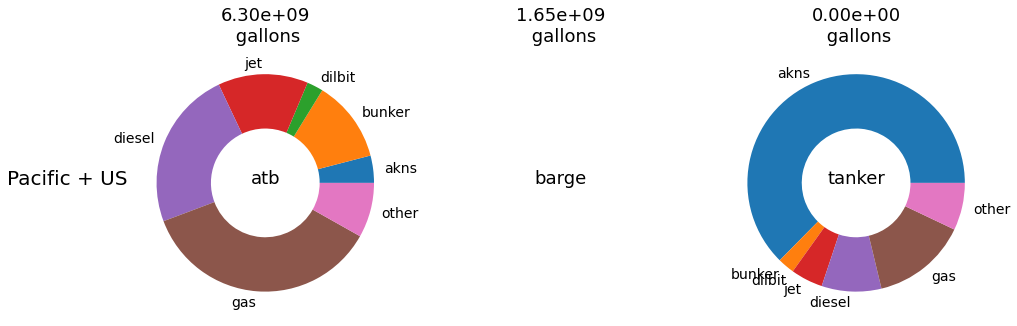

In [19]:
import matplotlib.pyplot as plt

# re-calc total transfers over all oil types
total_tanker = sum([ US['tanker'][oil]['total_gallons'] for oil in oil_types ])
total_atb    = sum([ US['atb'][oil]['total_gallons'] for oil in oil_types ])
total_barge  = sum([ US['barge'][oil]['total_gallons'] for oil in oil_types ])

total = [total_tanker, total_atb, total_barge]

plot_array = np.empty(len(oil_types))

fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))

plt.text(0, 0.5, 
         'Pacific + US ', 
         ha='left',
         fontsize=20,
         wrap=True,
         transform=plt.gcf().transFigure)

for j in range(len(vessel_types)):
    vessel = vessel_types[j]
    # create array of total oil volume by oil type for each vessel at each facility
    oil_index = 0
    for oil in oil_types:    
        plot_array[oil_index]=US[vessel][oil]['total_gallons']
        oil_index += 1

    axes[j].axis('equal')
    axes[j].set_title(f'{total[j]:4.2e}\n gallons',fontsize=18)

    if plot_array.sum()>0:
        axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = oil_types, textprops={'fontsize': 14})
    else:
        axes[j].axis('off')
    axes[j].text(0,0,vessel,ha='center',fontsize=18)

plt.savefig('US_combined.png')